In [1]:
# libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plot
import tensorflow as tf

from scipy.linalg import svd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.seasonal import MSTL
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input

from sklearn.preprocessing import MinMaxScaler


2024-11-24 20:06:38.490659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 20:06:38.564416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732471598.598016  107550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732471598.607928  107550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 20:06:38.698294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Read and preprocess the dataf
energy_data = pd.read_csv("NI_hourly.csv")
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])
energy_data['hour'] = energy_data['Datetime'].dt.hour
energy_data['date'] = energy_data['Datetime'].dt.date

# Sort chronologically by Datetime
energy_data = energy_data.sort_values('Datetime')
energy_data.set_index('Datetime',inplace=True)

In [3]:
# initial print check to see if everything is okay
print(energy_data)

                       NI_MW  hour        date
Datetime                                      
2004-05-01 01:00:00   9198.0     1  2004-05-01
2004-05-01 02:00:00   8570.0     2  2004-05-01
2004-05-01 03:00:00   8183.0     3  2004-05-01
2004-05-01 04:00:00   7917.0     4  2004-05-01
2004-05-01 05:00:00   7828.0     5  2004-05-01
...                      ...   ...         ...
2010-12-31 20:00:00  11585.0    20  2010-12-31
2010-12-31 21:00:00  11243.0    21  2010-12-31
2010-12-31 22:00:00  10825.0    22  2010-12-31
2010-12-31 23:00:00  10511.0    23  2010-12-31
2011-01-01 00:00:00  10042.0     0  2011-01-01

[58450 rows x 3 columns]


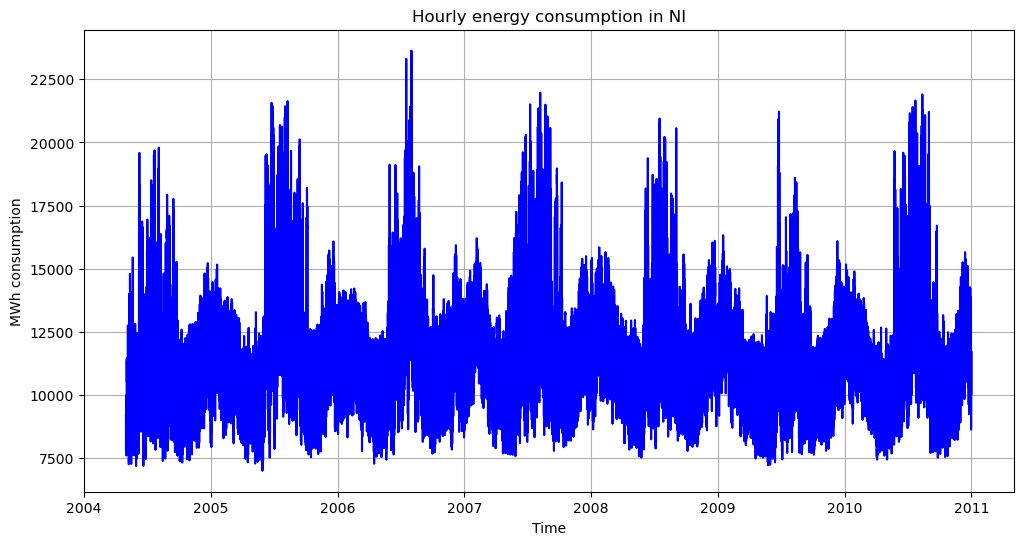

In [4]:

# Plot hourly consumption
plot.figure(figsize=(12, 6))
plot.plot(energy_data['NI_MW'], color='blue')
plot.xlabel('Time')
plot.ylabel('MWh consumption')
plot.title('Hourly energy consumption in NI')
plot.grid()
plot.show()

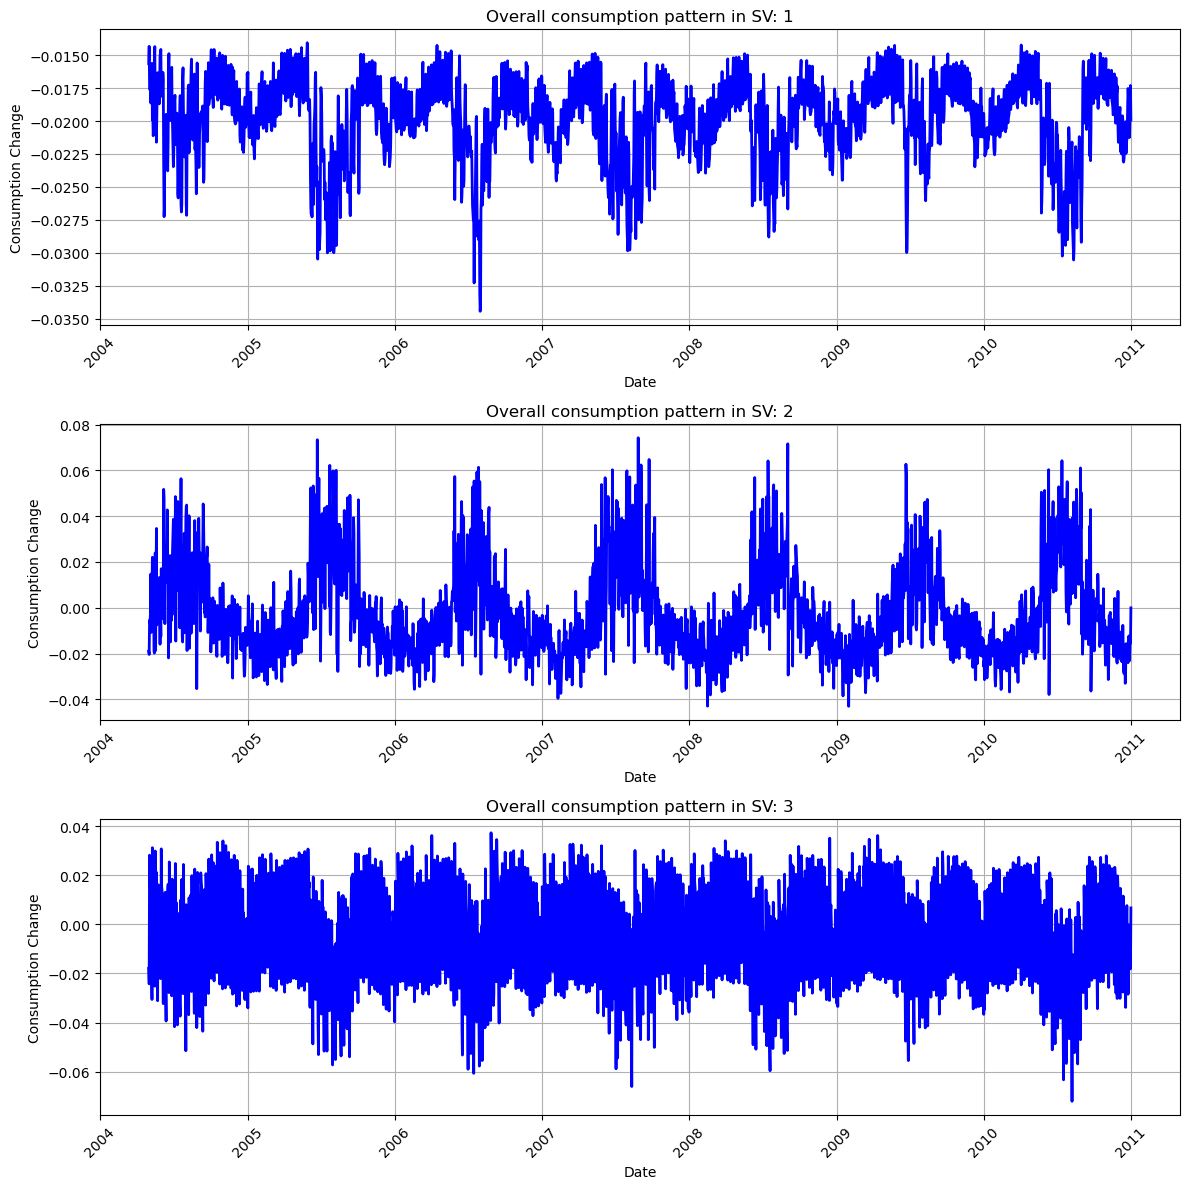

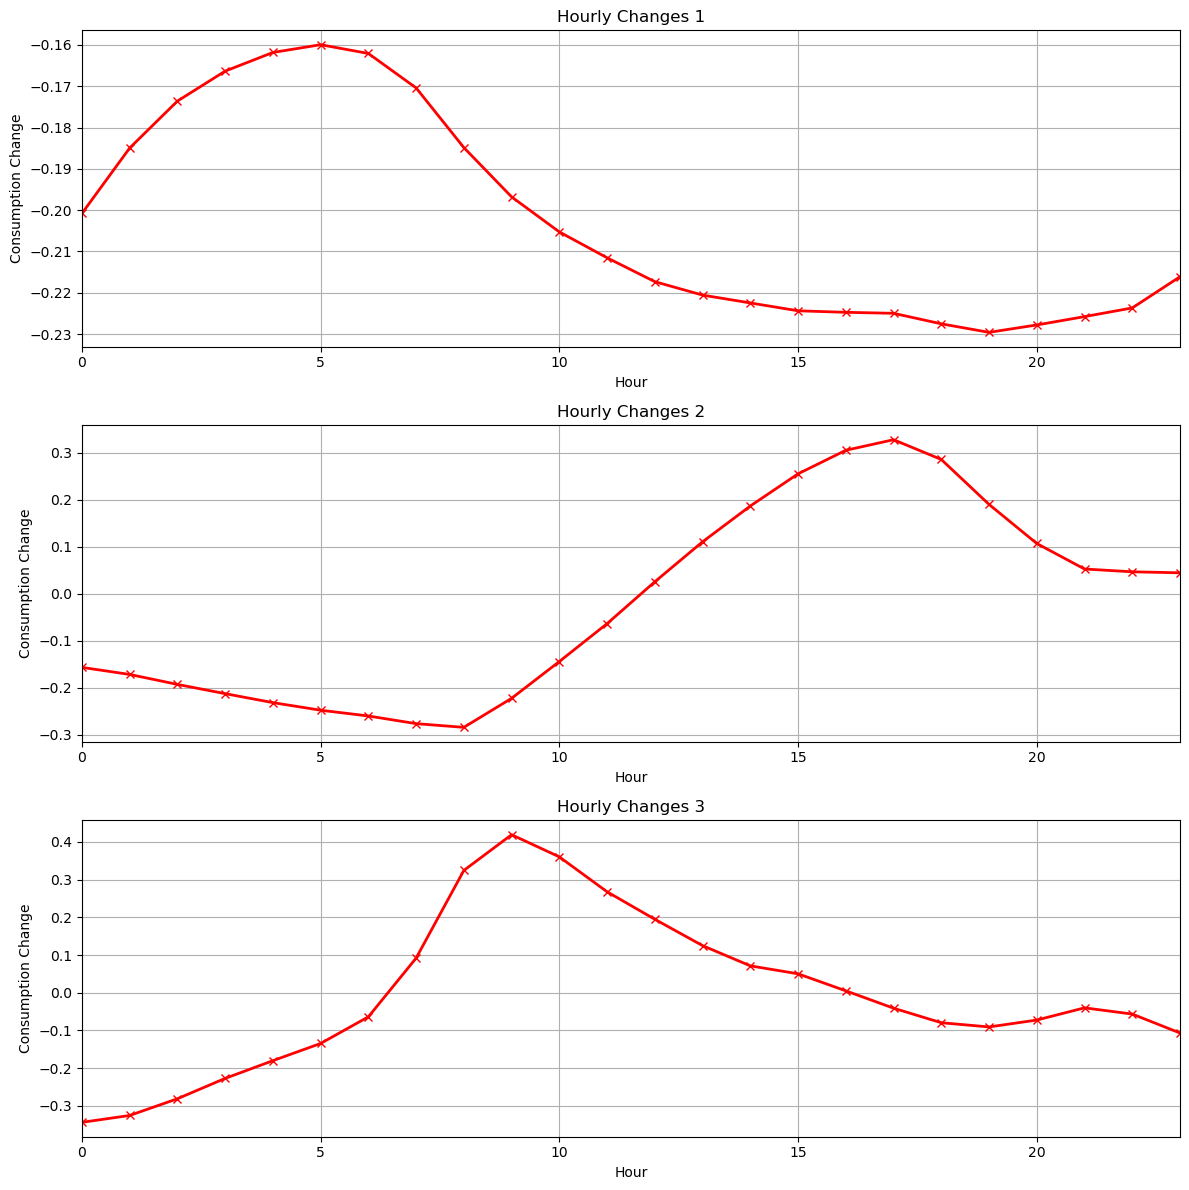

In [5]:
# Create pivot table for SVD analysis
pivoted_data = energy_data.pivot_table(
    values='NI_MW', 
    index='date',
    columns='hour',
    aggfunc='mean'
)
pivoted_data = pivoted_data.fillna(pivoted_data.mean())
matrix = pivoted_data.values

# Perform SVD
U, S, Vt = svd(matrix, full_matrices=False)
V = Vt.T

# Plot overall consumption patterns from SVD
plot.figure(figsize=(12, 12))
for i in range(3):
    plot.subplot(3, 1, i+1)
    plot.plot(pivoted_data.index, U[:, i], linewidth=2, color='blue')
    plot.title(f'Overall consumption pattern in SV: {i+1}')
    plot.xlabel('Date')
    plot.ylabel('Consumption Change')
    plot.grid(True)
    plot.xticks(rotation=45)
plot.tight_layout()
plot.show()

# Plot hourly patterns from SVD
plot.figure(figsize=(12, 12))
for i in range(3):
    plot.subplot(3, 1, i+1)
    plot.plot(range(24), V[:, i], 'rx-', linewidth=2)
    plot.title(f'Hourly Changes {i+1}')
    plot.xlabel('Hour')
    plot.ylabel('Consumption Change')
    plot.xlim(0, 23)
    plot.grid(True)
plot.tight_layout()
plot.show()

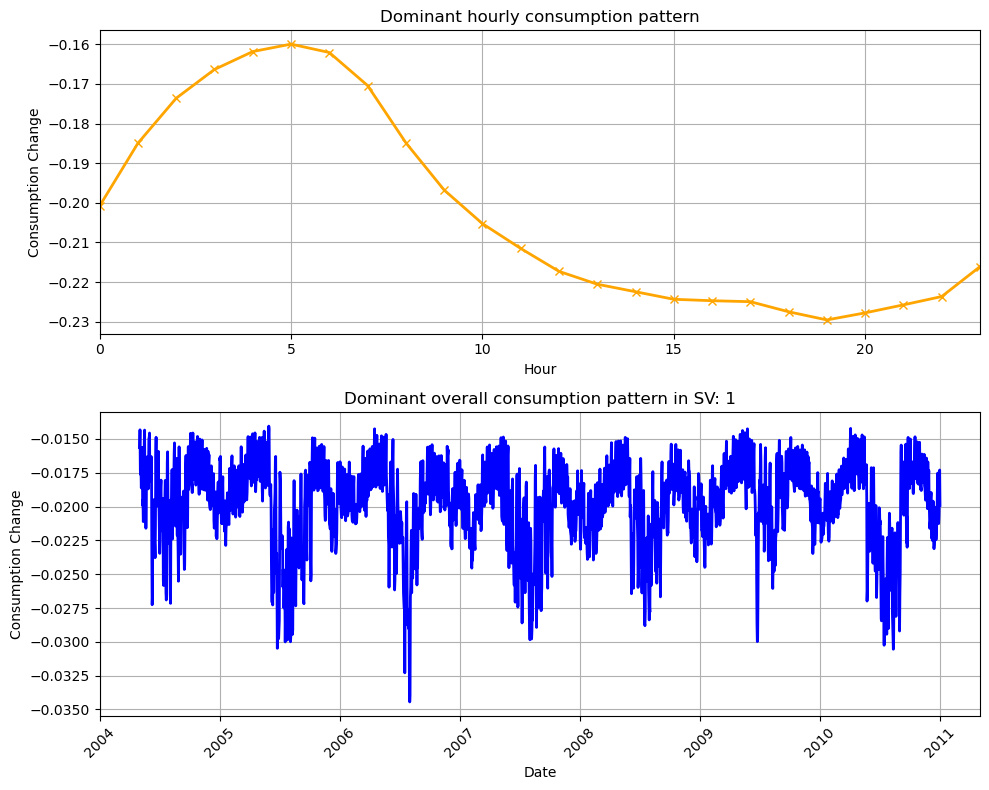

In [6]:
# Create figure with 2 subplots arranged vertically
fig, (ax1, ax2) = plot.subplots(2, 1, figsize=(10, 8))

# First subplot
hours = np.arange(24)  # 0:23
ax1.plot(hours, V[:,0], 'orange', marker='x', linewidth=2)
ax1.set_title('Dominant hourly consumption pattern')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Consumption Change')
ax1.set_xlim([0, 23])
ax1.grid(True)

# Second subplot
ax2.plot(pivoted_data.index, U[:, 0], linewidth=2, color='blue')  # Fixed this line
ax2.set_title(f'Dominant overall consumption pattern in SV: {1}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Consumption Change')
plot.setp(ax2.xaxis.get_ticklabels(), rotation=45)
ax2.grid(True)

# Adjust layout to prevent overlap
plot.tight_layout()

# Display the plot
plot.show()

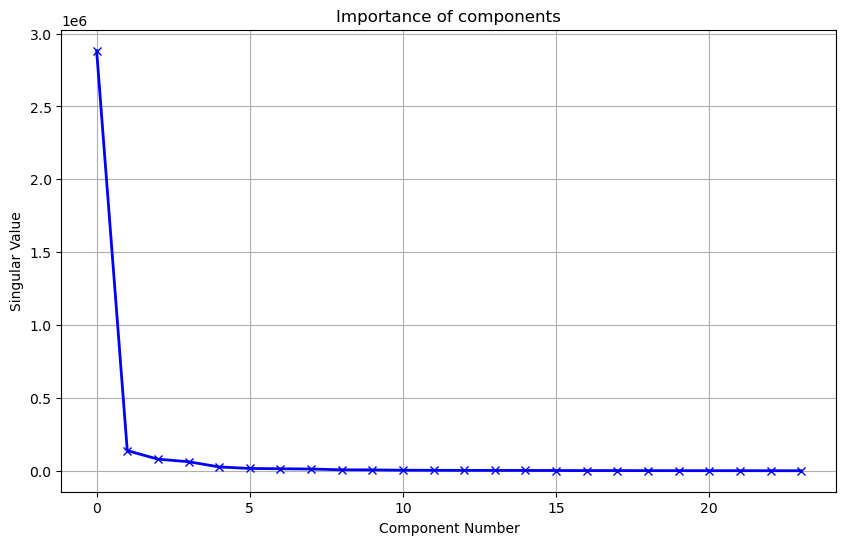

In [7]:
# Plot singular values

plot.figure(figsize=(10, 6))
plot.plot(S, 'bx-', linewidth=2)
plot.xlabel('Component Number')
plot.ylabel('Singular Value')
plot.title('Importance of components')
plot.grid(True)
plot.show()

In [8]:
# Index reset here - Just for Erics section with the decomp
energy_data = energy_data.reset_index()


In [9]:
print(energy_data['Datetime'])

0       2004-05-01 01:00:00
1       2004-05-01 02:00:00
2       2004-05-01 03:00:00
3       2004-05-01 04:00:00
4       2004-05-01 05:00:00
                ...        
58445   2010-12-31 20:00:00
58446   2010-12-31 21:00:00
58447   2010-12-31 22:00:00
58448   2010-12-31 23:00:00
58449   2011-01-01 00:00:00
Name: Datetime, Length: 58450, dtype: datetime64[ns]


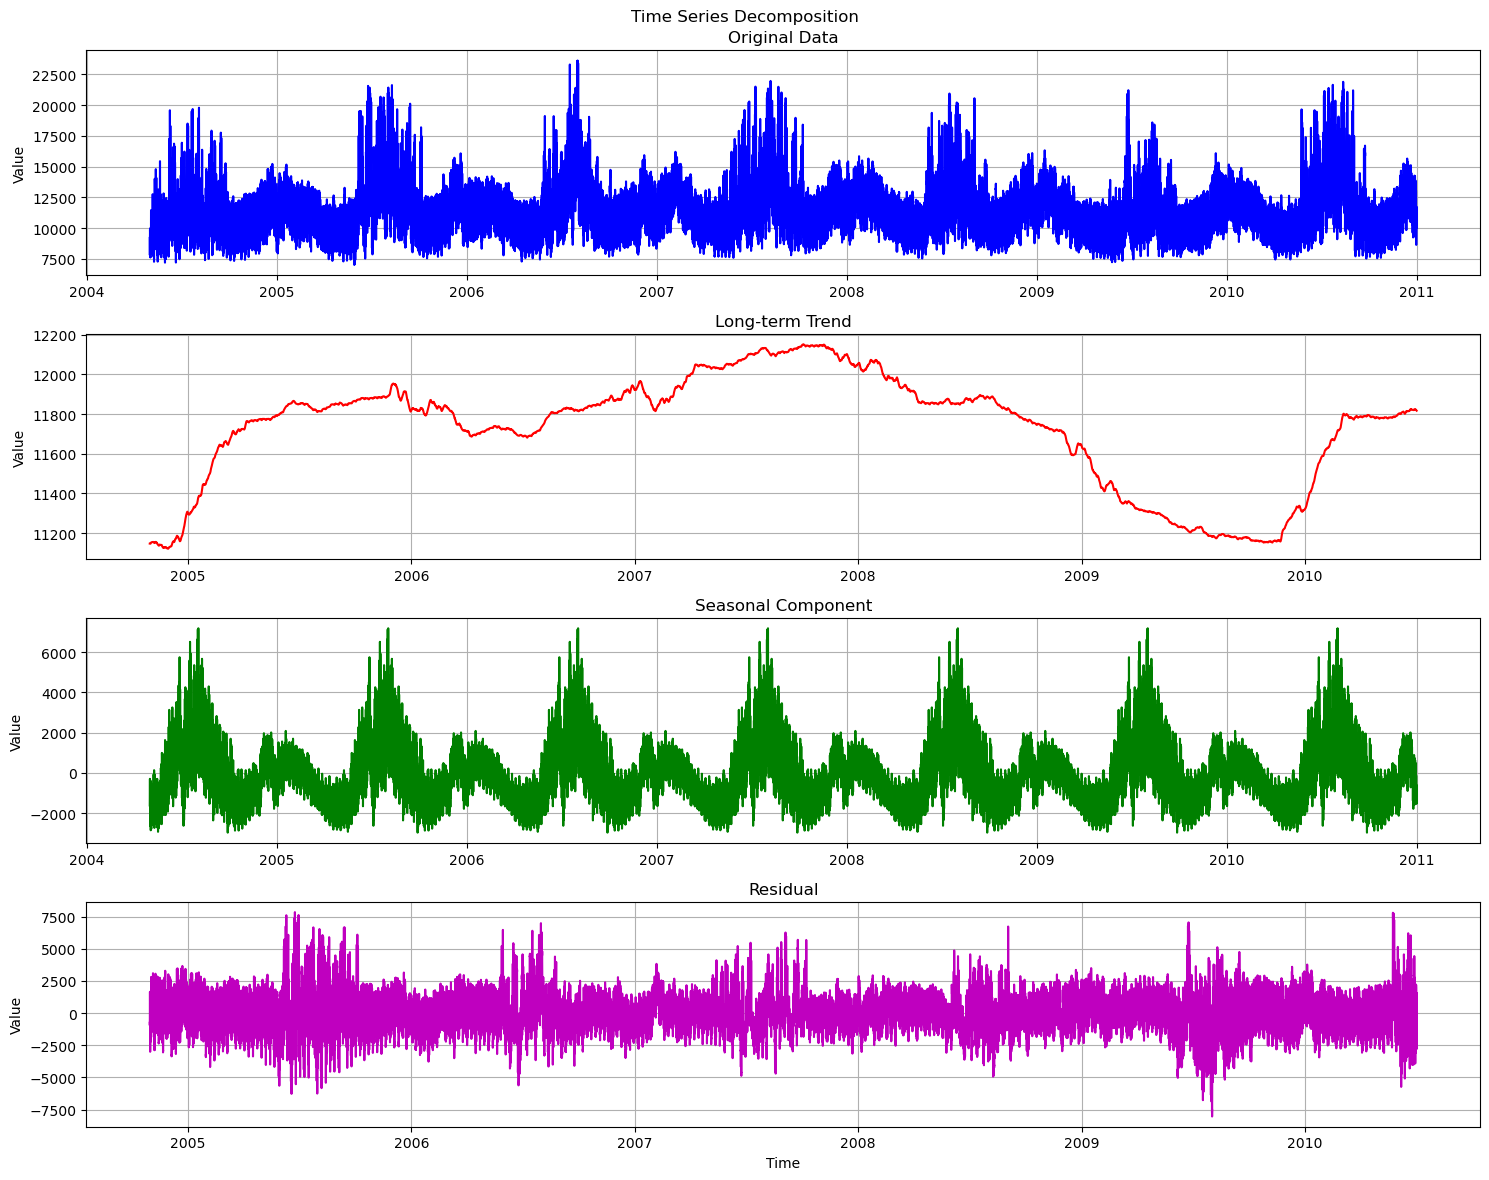

In [10]:
# Time series decomposition
ts_data = pd.Series(
    energy_data['NI_MW'].values,
    index=pd.DatetimeIndex(energy_data['Datetime']),
    name='NI_MW'
)
ts_data = ts_data.sort_index()

# Perform decomposition

# Yearly seasonality
decomposition = seasonal_decompose(
    ts_data,
    model="additive",
    period=24*365, # yearly seasonality
    extrapolate_trend=0
)


# Plot decomposition results
fig, (ax1, ax2, ax3, ax4) = plot.subplots(4, 1, figsize=(15, 12))

# Original Data
ax1.plot(ts_data.index, ts_data.values, 'b-', linewidth=1.5)
ax1.set_title('Original Data')
ax1.grid(True)
ax1.set_ylabel('Value')

# Trend
ax2.plot(ts_data.index, decomposition.trend, 'r-', linewidth=1.5)
ax2.set_title('Long-term Trend')
ax2.grid(True)
ax2.set_ylabel('Value')

# Seasonal
ax3.plot(ts_data.index, decomposition.seasonal, 'g-', linewidth=1.5)
ax3.set_title('Seasonal Component')
ax3.grid(True)
ax3.set_ylabel('Value')

# Residual
ax4.plot(ts_data.index, decomposition.resid, 'm-', linewidth=1.5)
ax4.set_title('Residual')
ax4.grid(True)
ax4.set_xlabel('Time')
ax4.set_ylabel('Value')


# Adjust layout for decomposition plot
plot.suptitle('Time Series Decomposition')
plot.tight_layout()
plot.show()

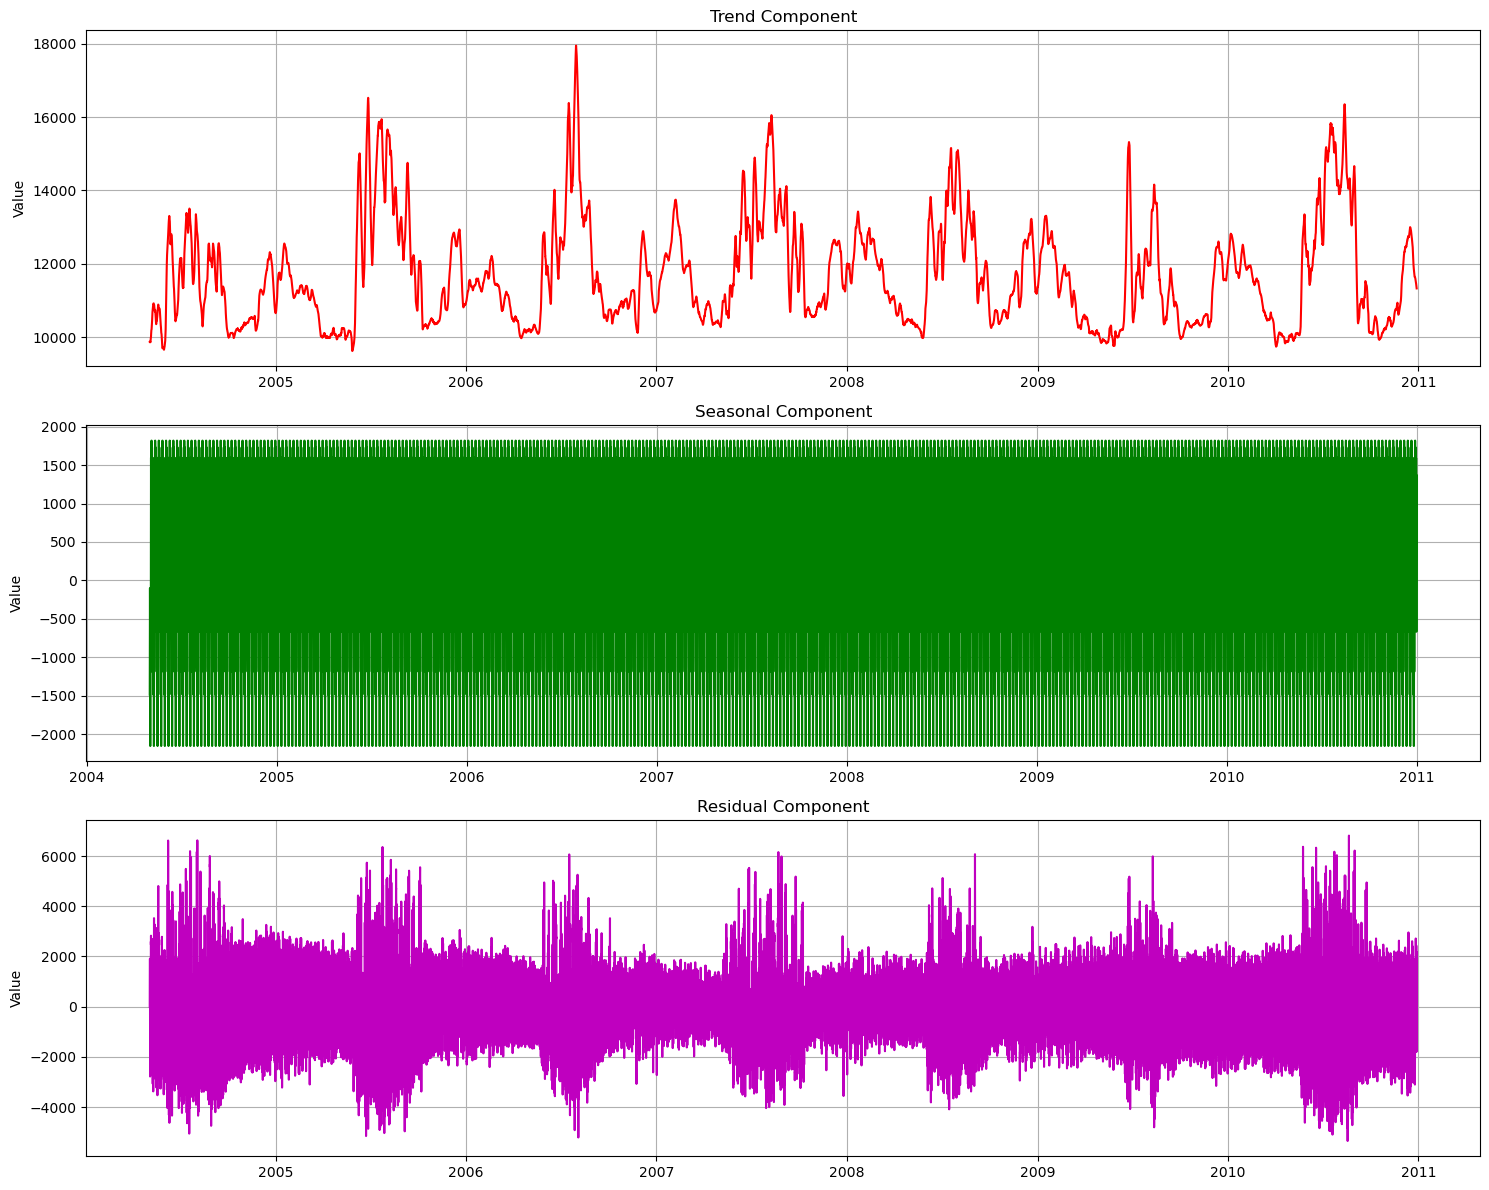

In [11]:
# Weekly decomposition

# Weekly seasonality 168 hours
weekly_decomposition = seasonal_decompose(
    ts_data, model="additive", period=24*7, extrapolate_trend=0
)
fig, (ax5, ax6, ax7) = plot.subplots(3, 1, figsize=(15, 12))

ax5.plot(weekly_decomposition.trend, 'r')
ax5.set_title('Trend Component')
ax5.set_ylabel('Value')
ax5.grid()

ax6.plot(weekly_decomposition.seasonal, 'g')
ax6.set_title('Seasonal Component')
ax6.set_ylabel('Value')
ax6.grid()

ax7.plot(weekly_decomposition.resid, 'm')
ax7.set_title('Residual Component')
ax7.set_ylabel('Value')
ax7.grid()

plot.tight_layout()
plot.show()

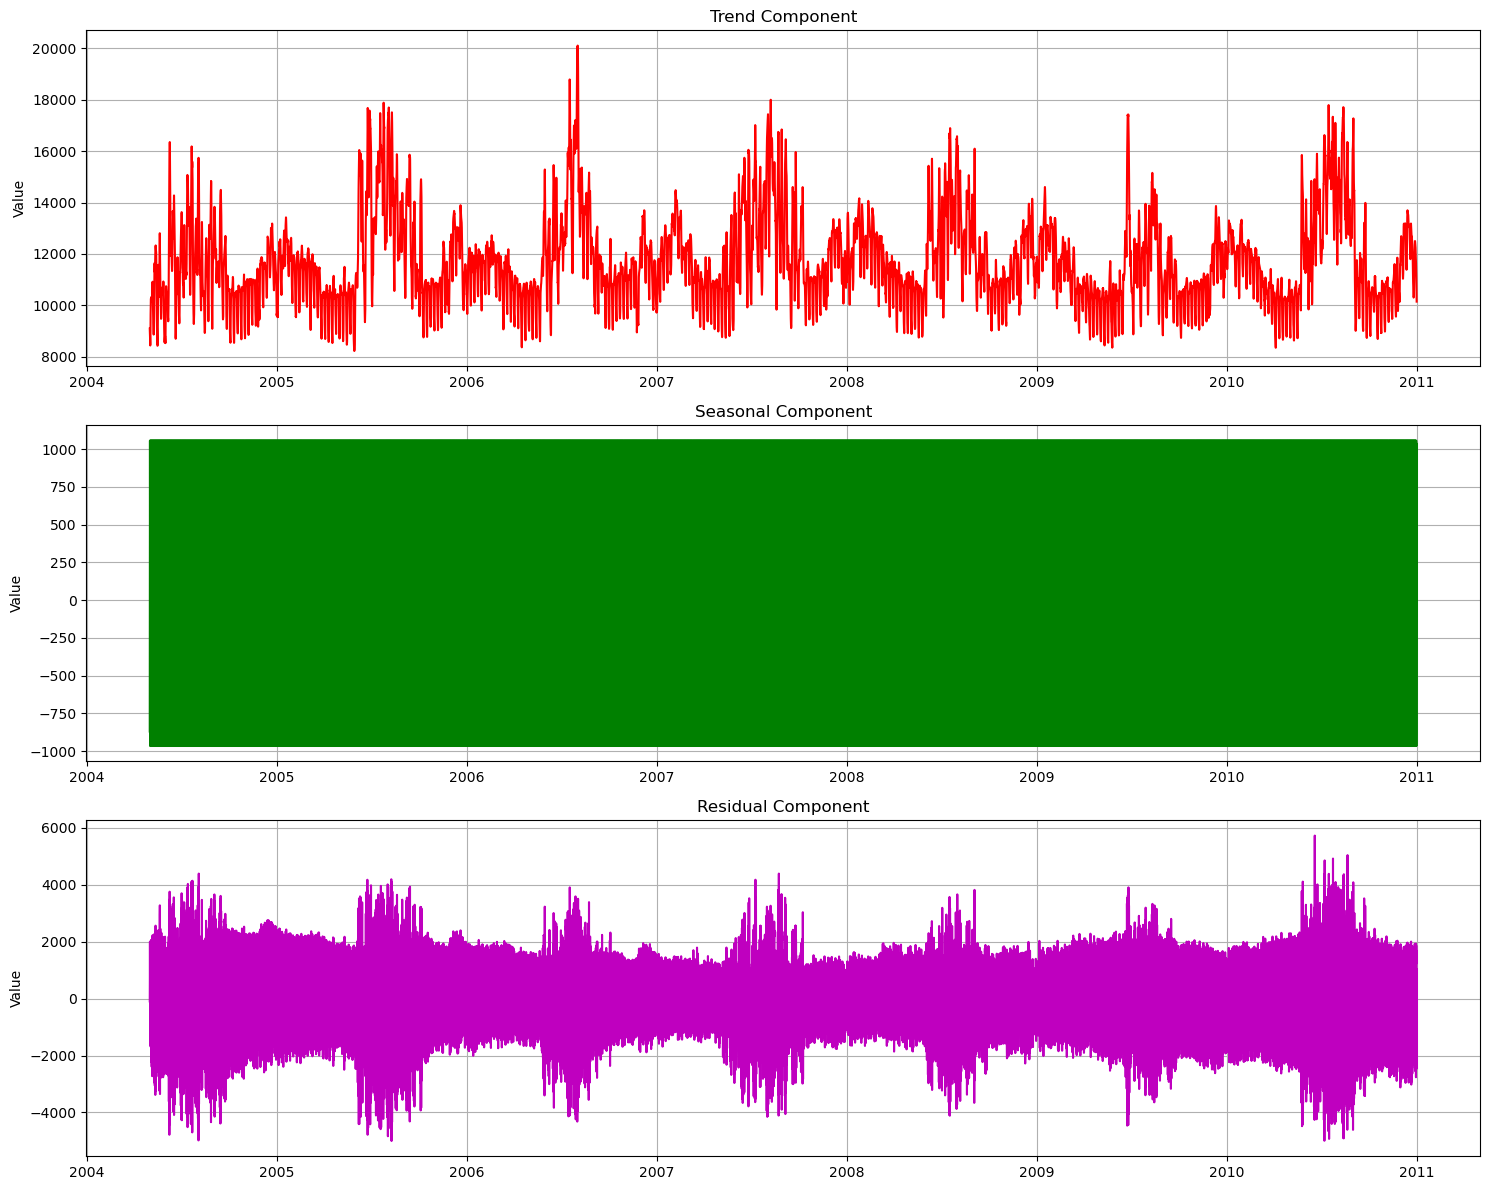

In [12]:
# Daily decomposition
# Daily seasonality 24 hours
daily_decomposition = seasonal_decompose(
    ts_data, model="additive", period=24, extrapolate_trend=0
)

fig, (ax8, ax9, ax10) = plot.subplots(3, 1, figsize=(15, 12))

ax8.plot(daily_decomposition.trend, 'r')
ax8.set_title('Trend Component')
ax8.set_ylabel('Value')
ax8.grid()

ax9.plot(daily_decomposition.seasonal, 'g')
ax9.set_title('Seasonal Component')
ax9.set_ylabel('Value')
ax9.grid()

ax10.plot(daily_decomposition.resid, 'm')
ax10.set_title('Residual Component')
ax10.set_ylabel('Value')
ax10.grid()

plot.tight_layout()
plot.show()

<Figure size 1000x600 with 0 Axes>

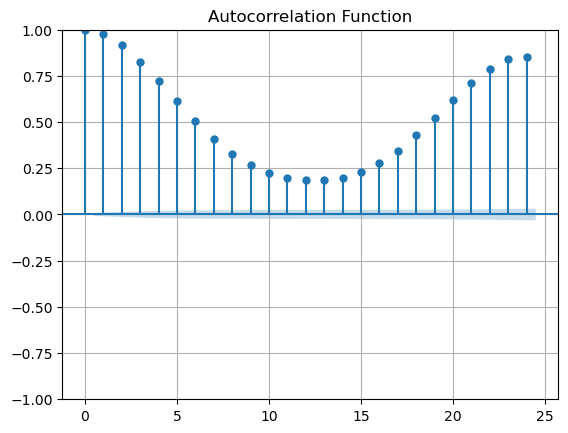

In [13]:
# Plot autocorrelation
plot.figure(figsize=(10, 6))
plot_acf(energy_data['NI_MW'], lags=24)
plot.grid(True)
plot.title('Autocorrelation Function')
plot.show()

In [14]:
# data statistics

print("Analyzing time steps...")

# Sort by datetime and calculate time differences
energy_data = energy_data.sort_values('Datetime')
time_diffs = energy_data['Datetime'].diff()

# Get unique time differences
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isnull(unique_diffs)]

print("Unique time differences found:")
for diff in unique_diffs:
    count = len(time_diffs[time_diffs == diff])
    print(f"- {diff}: {count} occurrences")

# Analyze missing values
print("\nMissing values per column:")
missing_values = energy_data.isnull().sum()


for col in energy_data.columns:
    print(f"{col}: {missing_values[col]}")


Analyzing time steps...
Unique time differences found:
- 3600000000000 nanoseconds: 58435 occurrences
- 7200000000000 nanoseconds: 14 occurrences

Missing values per column:
Datetime: 0
NI_MW: 0
hour: 0
date: 0


In [15]:
print("Analyzing time steps...")

# Sort by datetime and calculate time differences
energy_data = energy_data.sort_values('Datetime')
time_diffs = energy_data['Datetime'].diff()

# Get unique time differences
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isnull(unique_diffs)]

print("Unique time differences found:")
for diff in unique_diffs:
    count = len(time_diffs[time_diffs == diff])
    print(f"- {diff}: {count} occurrences")

# Find rows where time diff is 2 hours 
two_hour_mask = time_diffs == pd.Timedelta(hours=2)

print("\nTwo hour time steps found:")
for prev, curr in zip(energy_data['Datetime'].shift()[two_hour_mask], 
                     energy_data['Datetime'][two_hour_mask]):
    print(f"Gap between {prev} and {curr}")

# Analyze missing values
print("\nMissing values per column:")
missing_values = energy_data.isnull().sum()

for col in energy_data.columns:
    print(f"{col}: {missing_values[col]}")

Analyzing time steps...
Unique time differences found:
- 3600000000000 nanoseconds: 58435 occurrences
- 7200000000000 nanoseconds: 14 occurrences

Two hour time steps found:
Gap between 2004-10-31 01:00:00 and 2004-10-31 03:00:00
Gap between 2005-04-03 02:00:00 and 2005-04-03 04:00:00
Gap between 2005-10-30 01:00:00 and 2005-10-30 03:00:00
Gap between 2006-04-02 02:00:00 and 2006-04-02 04:00:00
Gap between 2006-10-29 01:00:00 and 2006-10-29 03:00:00
Gap between 2007-03-11 02:00:00 and 2007-03-11 04:00:00
Gap between 2007-11-04 01:00:00 and 2007-11-04 03:00:00
Gap between 2008-03-09 02:00:00 and 2008-03-09 04:00:00
Gap between 2008-11-02 01:00:00 and 2008-11-02 03:00:00
Gap between 2009-03-08 02:00:00 and 2009-03-08 04:00:00
Gap between 2009-11-01 01:00:00 and 2009-11-01 03:00:00
Gap between 2010-03-14 02:00:00 and 2010-03-14 04:00:00
Gap between 2010-11-07 01:00:00 and 2010-11-07 03:00:00
Gap between 2010-12-09 23:00:00 and 2010-12-10 01:00:00

Missing values per column:
Datetime: 0
NI

In [16]:
# Index swapping 
energy_data.index = energy_data['Datetime']
print(energy_data.index)
#print(energy_data['NI_MW'])

DatetimeIndex(['2004-05-01 01:00:00', '2004-05-01 02:00:00',
               '2004-05-01 03:00:00', '2004-05-01 04:00:00',
               '2004-05-01 05:00:00', '2004-05-01 06:00:00',
               '2004-05-01 07:00:00', '2004-05-01 08:00:00',
               '2004-05-01 09:00:00', '2004-05-01 10:00:00',
               ...
               '2010-12-31 15:00:00', '2010-12-31 16:00:00',
               '2010-12-31 17:00:00', '2010-12-31 18:00:00',
               '2010-12-31 19:00:00', '2010-12-31 20:00:00',
               '2010-12-31 21:00:00', '2010-12-31 22:00:00',
               '2010-12-31 23:00:00', '2011-01-01 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=58450, freq=None)


In [17]:
# Params 
# Prepare sliding window dataset (X, Y)
window_size = 24 * 7
# Forecasting one hour
forecast_horizon = 1
# Number of timesteps moved forward each iteration
stride = 168 

In [18]:
# Init scaler -- Use minmax scaler suggested by lit review
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape decomp vals for Predictions
residual = daily_decomposition.resid.dropna().values.reshape(-1, 1)
trend = daily_decomposition.trend.dropna().values.reshape(-1, 1)
seasonal = daily_decomposition.seasonal.dropna().values.reshape(-1, 1)

# Scale decomp values for Predictions
residual_scaled = scaler.fit_transform(residual)
trend_scaled = scaler.fit_transform(trend)
seasonal_scaled = scaler.fit_transform(seasonal)

# Make sure X and Y values align - predictions done on resixs
X_residual = residual_scaled[:-forecast_horizon]  
Y_residual = residual_scaled[forecast_horizon:]


In [19]:
# Personal unnecessary garbage -- J
print(len(residual) - window_size - forecast_horizon, stride)
print(49521/stride)

58257 168
294.76785714285717


In [20]:
# Fix - Don'r run if no problems exist
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=0"


In [21]:
# Step 2: Build the dataset for autoregressive modeling using residuals
T = 24  # Number of lags
X = []  # Feature matrix
Y = []  # Target variable (next residual)

for t in range(len(residual) - T):
    X.append(residual_scaled[t:t + T])  # Using the previous T residuals as features
    Y.append(residual_scaled[t + T])  # The next residual as the target

X = np.array(X).reshape(-1, T)  # Reshape for input to the model (samples, time steps)
Y = np.array(Y)

# Step 3: Define the autoregressive model using a Dense neural network
i = Input(shape=(T,))  # Input shape is the number of lags (T)
x = Dense(1)(i)  # A single dense layer that outputs a single value (next residual)
model = Model(i, x)

# Compile the model
model.compile(
    loss='mse',  # Mean Squared Error for regression
    optimizer='adam',
    metrics = ['mse']
)

autoreg_predictions = []
autoreg_actual_values = []
autoreg_timestamps = []
#window_size = 300  # You can adjust this to the size of your training data window
#stride =   # How much to roll the window at each iteration (1 means it shifts by 1 residual each time)

# Iterate through the residuals with a rolling window
for start in range(0, len(X) - window_size, stride):
    end = start + window_size
    X_train = X[start:end]  # Training data (window_size previous residuals)
    Y_train = Y[start:end]  # Target values (next residuals)
    
    # Step 4: Train the model with the current window
    model.fit(X_train, Y_train, epochs=3, batch_size=64)

    # Predict with previous residual - store vars for plots and moveforward
    predicted_residual = model.predict(X[end:end+1]) 
    autoreg_predictions.append(predicted_residual.flatten())  
    autoreg_actual_values.append(Y[end])  
    autoreg_timestamps.append(energy_data['Datetime'][end])

# Done
print ('Done')

Epoch 1/3


2024-11-24 20:06:47.952329: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-24 20:06:47.952352: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: joonas
2024-11-24 20:06:47.952356: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: joonas
2024-11-24 20:06:47.952451: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.183.1
2024-11-24 20:06:47.952466: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.183.1
2024-11-24 20:06:47.952468: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.183.1


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0521 - mse: 0.0521  
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504 - mse: 0.0504  
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0448 - mse: 0.0448  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0763 - mse: 0.0763
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0698 - mse: 0.0698  
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0694 - mse: 0.0694  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0597 - mse: 0.0597  
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0619 - mse: 0.0619  
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608 - mse: 0.0608  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451 - mse: 0.0451
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433 - mse: 0.0433  
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

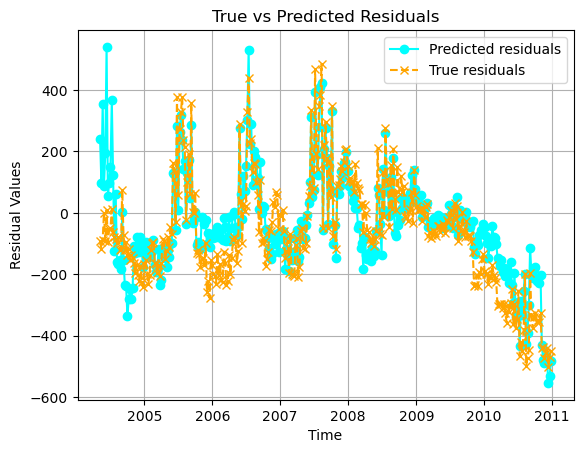

In [23]:
in_predicted_residuals = scaler.inverse_transform(np.array(autoreg_predictions).reshape(-1, 1)).flatten()

actual_residuals = autoreg_actual_values
actual_residuals = scaler.inverse_transform(np.array(actual_residuals).reshape(-1, 1)).flatten()

# Redo seasonal and trend values
autoreg_seasonal_values = seasonal[len(seasonal) - len(in_predicted_residuals):].flatten()
autoreg_trend_values = trend[len(trend) - len(in_predicted_residuals):].flatten()

# Reseasonalize predictions
a_reg_reseasonalized_predictions = in_predicted_residuals + autoreg_seasonal_values + autoreg_trend_values

# Reseasonalize actual_values
a_reg_reseasonalized_true = actual_residuals + autoreg_seasonal_values + autoreg_trend_values


plot.plot(autoreg_timestamps, in_predicted_residuals, linestyle='-', marker = 'o', color = 'cyan', label = 'Predicted residuals')
plot.plot(autoreg_timestamps, actual_residuals, linestyle='--', marker = 'x', color = 'orange', label = 'True residuals')
plot.xlabel('Time')
plot.ylabel('Residual Values')
plot.title('True vs Predicted Residuals')
plot.legend()
plot.grid()
plot.show()


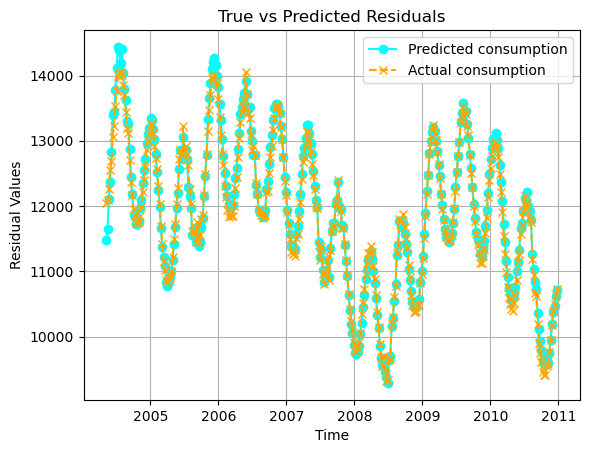

In [124]:
plot.plot(autoreg_timestamps,a_reg_reseasonalized_predictions, linestyle='-', marker = 'o', color = 'cyan', label = 'Predicted consumption')
plot.plot(autoreg_timestamps,a_reg_reseasonalized_true, linestyle='--', marker = 'x', color = 'orange', label = 'Actual consumption')
plot.xlabel('Time')
plot.ylabel('Residual Values')
plot.title('True vs Predicted Residuals')
plot.legend()
plot.grid()
plot.show()

In [27]:
# Variable storage

all_predictions = []
all_true_values = []
timestamps = []  

# Hyperparams
epochs = 3
network_size = 256

# Prepare model once before the loop
model = Sequential([
    LSTM(network_size),
    Dense(1, activation='relu')
])

#  Compile model with metrics etc...
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'root_mean_squared_error'])

for start in range(0, len(residual) - window_size - forecast_horizon, stride):
    train_start = start
    train_end = start + window_size
    val_start = train_end
    val_end = val_start + forecast_horizon

    # Split residual into rolling window training and validation sets
    X_train = X_residual[train_start:train_end].reshape(-1, 1, 1)  # Add time and feature dimensions
    Y_train = Y_residual[train_start:train_end]
    X_val = X_residual[val_start:val_end].reshape(-1, 1, 1)
    Y_val = Y_residual[val_start:val_end]

    # Model training
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, verbose=1)

    # Evaluate the model on validation set - exit criteria could be set here
    predictions = model.predict(X_val, batch_size=64)
    
    # Store predictions and actual values
    all_predictions.extend(predictions.flatten())  # Flatten to avoid any dimension issues
    all_true_values.extend(Y_val.flatten())  # Flatten the true values similarly

    # Store the corresponding timestamps for plotting
    timestamps.extend(energy_data['Datetime'][val_start:val_end].values)

Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2218 - mae: 0.4560 - root_mean_squared_error: 0.4708 - val_loss: 0.1694 - val_mae: 0.4116 - val_root_mean_squared_error: 0.4116
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1699 - mae: 0.3968 - root_mean_squared_error: 0.4121 - val_loss: 0.1273 - val_mae: 0.3569 - val_root_mean_squared_error: 0.3569
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1268 - mae: 0.3378 - root_mean_squared_error: 0.3560 - val_loss: 0.0896 - val_mae: 0.2994 - val_root_mean_squared_error: 0.2994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1066 - mae: 0.2952 - root_mean_squared_error: 0.3261 - val_loss: 0.0543 - val_mae: 0.2329 - val_root_mean_squared_error: 0.2329
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0632 - mae: 0.2208 - root_mean_squared_error: 0.2513 - val_loss: 0.0287 - val_mae: 0.1693 - val_root_mean_squared_error: 0.1693
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0

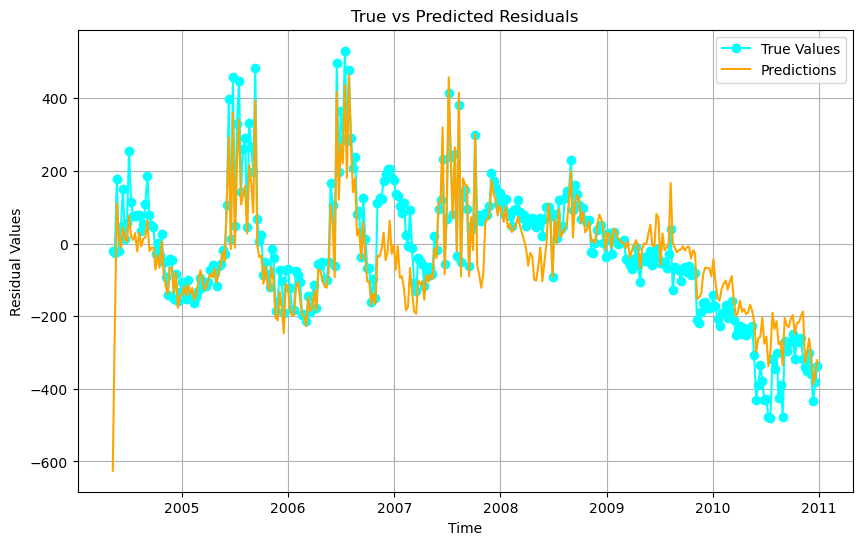

In [28]:
all_predictions_original = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
all_true_values_original = scaler.inverse_transform(np.array(all_true_values).reshape(-1, 1)).flatten()

# Redo seasonal and trend values
seasonal_values = seasonal[len(seasonal) - len(all_predictions_original):].flatten()
trend_values = trend[len(trend) - len(all_predictions_original):].flatten()

# Reseasonalize predictions
reseasonalized_predictions = all_predictions_original + seasonal_values + trend_values

plot.figure(figsize=(10, 6))
plot.plot(timestamps, all_true_values_original, label='True Values', color='cyan', linestyle='-', marker='o')
plot.plot(timestamps, all_predictions_original, label='Predictions', color='orange', linestyle='-')

# Add labels and title

plot.xlabel('Time')
plot.ylabel('Residual Values')
plot.title('True vs Predicted Residuals')
plot.legend()
plot.grid()
plot.show()

[ 9198.  8570.  8183. ... 10825. 10511. 10042.]


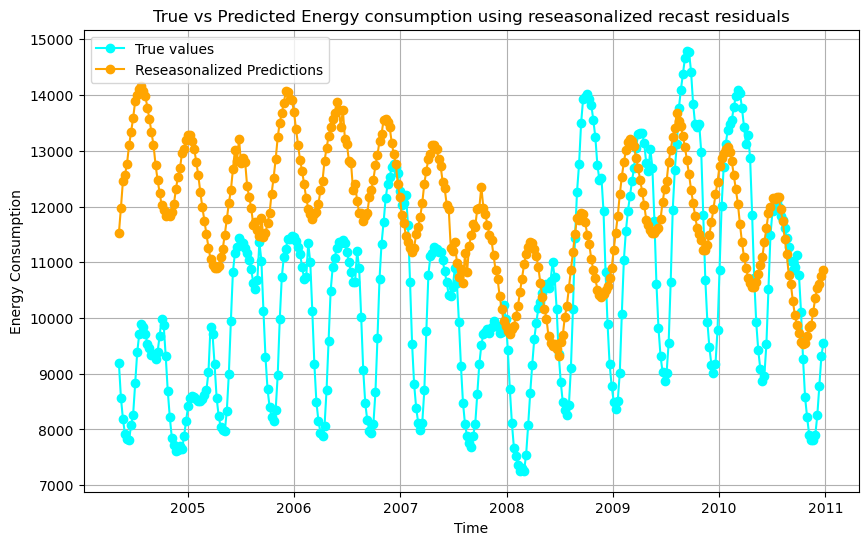

In [29]:
#energy_data['NI_MW_unscaled'] = scaler.inverse_transform(energy_data[['NI_MW']])
original_consumption_data = energy_data['NI_MW'].values
print(original_consumption_data)
plot.figure(figsize=(10, 6))
plot.plot(timestamps, original_consumption_data[:len(timestamps)], label='True values', color='cyan', linestyle='-', marker='o')
plot.plot(timestamps, reseasonalized_predictions, label='Reseasonalized Predictions', color='orange', marker='o')
plot.xlabel('Time')
plot.ylabel('Energy Consumption')
plot.title('True vs Predicted Energy consumption using reseasonalized recast residuals')
plot.legend()
plot.grid()
plot.show()